In [19]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [20]:
parcellations_df = pd.read_csv("Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv")
# add column for brain hemisphere. If LH is in ROI Name, then it is LH, otherwise it is RH
parcellations_df['Hemisphere'] = np.where(parcellations_df['ROI Name'].str.contains("LH"), "LH", "RH")
# network mapping
mapping = {
    "Vis" : "VIS",
    "SomMot" : "MOT",
    "DorsAttn" : "DAN",
    "SalVentAttn" : "VAN",
    "Limbic" : "LBN",
    "Cont" : "FPN",
    "Default" : "DMN"
}
mapping_order = {}
for i, k in enumerate(mapping.keys()):
    mapping_order[mapping[k]] = i
parcellations_df['Network'] = ""
for network in mapping.keys():
    parcellations_df['Network'] = np.where(parcellations_df['ROI Name'].str.contains(network), mapping[network], parcellations_df['Network'])

parcellations_df.sort_values(by=['Network', "Hemisphere"], key=lambda x: x.map(mapping_order), inplace=True)
parcellations_df.reset_index(inplace=True)
parcellations_df

index  ROI Label                        ROI Name   R   A   S Hemisphere  \
0        0          1              7Networks_LH_Vis_1 -32 -42 -20         LH   
1        1          2              7Networks_LH_Vis_2 -30 -32 -18         LH   
2        2          3              7Networks_LH_Vis_3 -36 -62 -16         LH   
3        3          4              7Networks_LH_Vis_4 -24 -54  -8         LH   
4        4          5              7Networks_LH_Vis_5 -24 -72 -10         LH   
..     ...        ...                             ...  ..  ..  ..        ...   
395    395        396  7Networks_RH_Default_pCunPCC_5   4 -64  32         RH   
396    396        397  7Networks_RH_Default_pCunPCC_6   6 -38  34         RH   
397    397        398  7Networks_RH_Default_pCunPCC_7   4 -20  36         RH   
398    398        399  7Networks_RH_Default_pCunPCC_8  10 -52  36         RH   
399    399        400  7Networks_RH_Default_pCunPCC_9   8 -50  44         RH   

    Network  
0       VIS  
1       VIS  
2       VIS  
3       VIS  
4       VIS  
..      ...  
395     DMN  
396     DMN  
397     DMN  
398     DMN  
399     DMN  

[400 rows x 8 columns]

In [21]:
# load Schaefer400Yeo7.mat
import scipy
indices_mat = scipy.io.loadmat("Schaefer400Yeo7.mat")
indices_array_LH = indices_mat["Schaefer400Yeo7"][0][0][0][0][:200]
indices_array_RH = indices_mat["Schaefer400Yeo7"][0][0][0][0][200:]
# for each unique value, get the first and last index of that value
indices_LH = []
indices_RH = []
for i in np.unique(indices_array_LH):
    indices_LH.append([np.where(indices_array_LH == i)[0][0], np.where(indices_array_LH == i)[0][-1]])
for i in np.unique(indices_array_RH):
    indices_RH.append([np.where(indices_array_RH == i)[0][0], np.where(indices_array_RH == i)[0][-1]])
indices_LH = np.array(indices_LH)
indices_RH = np.array(indices_RH) + 200
networks_ids_for_plot_LH = {}
for i, network in enumerate(indices_LH):
    networks_ids_for_plot_LH[list(mapping.values())[i]+"_LH"] = network
networks_ids_for_plot_RH = {}
for i, network in enumerate(indices_RH):
    networks_ids_for_plot_RH[list(mapping.values())[i]+"_RH"] = network
networks_ids_for_plot = {**networks_ids_for_plot_LH, **networks_ids_for_plot_RH}
print(networks_ids_for_plot)

{'VIS_LH': array([ 0, 30], dtype=int64), 'MOT_LH': array([31, 67], dtype=int64), 'DAN_LH': array([68, 90], dtype=int64), 'VAN_LH': array([ 91, 112], dtype=int64), 'LBN_LH': array([113, 125], dtype=int64), 'FPN_LH': array([126, 147], dtype=int64), 'DMN_LH': array([148, 199], dtype=int64), 'VIS_RH': array([200, 229], dtype=int64), 'MOT_RH': array([230, 269], dtype=int64), 'DAN_RH': array([270, 292], dtype=int64), 'VAN_RH': array([293, 317], dtype=int64), 'LBN_RH': array([318, 330], dtype=int64), 'FPN_RH': array([331, 360], dtype=int64), 'DMN_RH': array([361, 399], dtype=int64)}


In [22]:
att_weights = np.squeeze(np.load("../code/attention_weights.npy"))
att_weights.shape

(608, 400, 400)

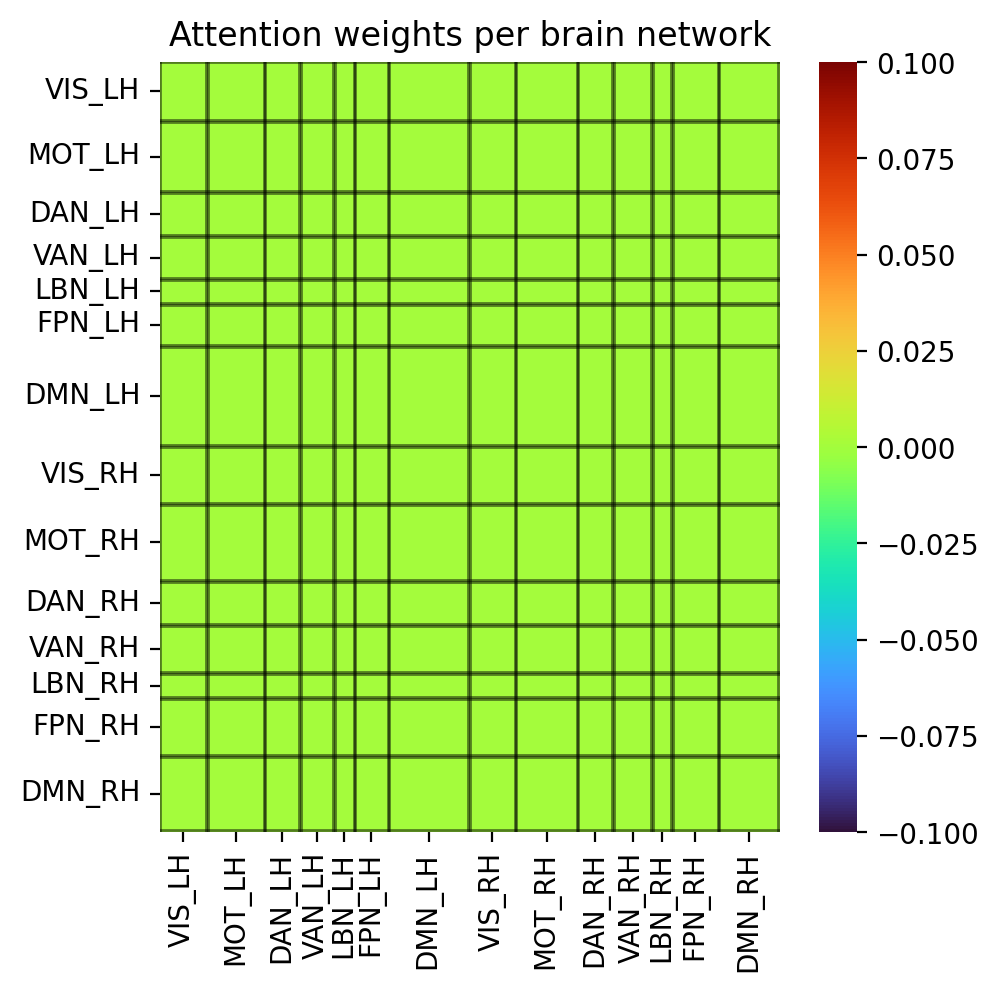

In [23]:
plt.figure(figsize=(5, 5), dpi=200)
sns.heatmap(att_weights.mean(axis=0), cmap="turbo")
# add xticks in the middle of networks indicated by network_ids_for_plot
xticks = []
for k, v in networks_ids_for_plot.items():
    xticks.append(np.mean(v))
yticks = xticks
# add network name on the xticks
xticklabels = list(networks_ids_for_plot.keys())
yticklabels = xticklabels
# add vlines to separate networks
lw = 1
alpha = 0.5
for v in networks_ids_for_plot.values():
    plt.axvline(v[0], color="black", linewidth=lw, alpha=alpha)
    plt.axhline(v[0], color="black", linewidth=lw, alpha=alpha)
    plt.axvline(v[1], color="black", linewidth=lw, alpha=alpha)
    plt.axhline(v[1], color="black", linewidth=lw, alpha=alpha)

plt.xticks(ticks=xticks, labels=xticklabels, rotation=90)
plt.yticks(ticks=yticks, labels=yticklabels, rotation=0)
plt.title("Attention weights per brain network")
plt.show()

In [24]:
def network_mean(matrix, network_ids=networks_ids_for_plot):
    mean_matrix = np.zeros_like(matrix)
    for k1, v1 in network_ids.items():
        for k2, v2 in network_ids.items():
            mean_matrix[v1[0]:v1[1]+1, v2[0]:v2[1]+1] = matrix[v1[0]:v1[1]+1, v2[0]:v2[1]+1].flatten().mean()
    return mean_matrix

Text(0.5, 1.0, 'Attention weights per brain network')

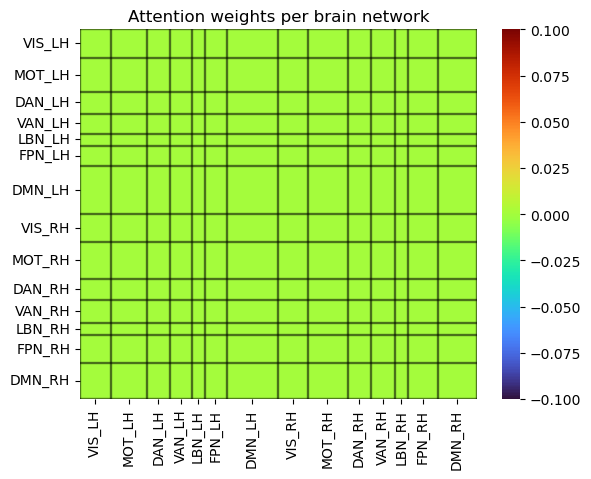

In [25]:
att_weights_mean = network_mean(att_weights.mean(axis=0))
        
sns.heatmap(att_weights_mean, cmap="turbo")
plt.xticks(ticks=xticks, labels=xticklabels, rotation=90)
plt.yticks(ticks=yticks, labels=yticklabels, rotation=0)
for v in networks_ids_for_plot.values():
    plt.axvline(v[0], color="black", linewidth=lw, alpha=alpha)
    plt.axhline(v[0], color="black", linewidth=lw, alpha=alpha)
    plt.axvline(v[1], color="black", linewidth=lw, alpha=alpha)
    plt.axhline(v[1], color="black", linewidth=lw, alpha=alpha)

plt.title("Attention weights per brain network")

In [26]:
attributions = np.load("../code/attributions.npy")
    
attributions_cmap = "icefire"
# attributions_cmap = "vlag"

In [27]:
attributions.shape

(9, 32, 400, 400)

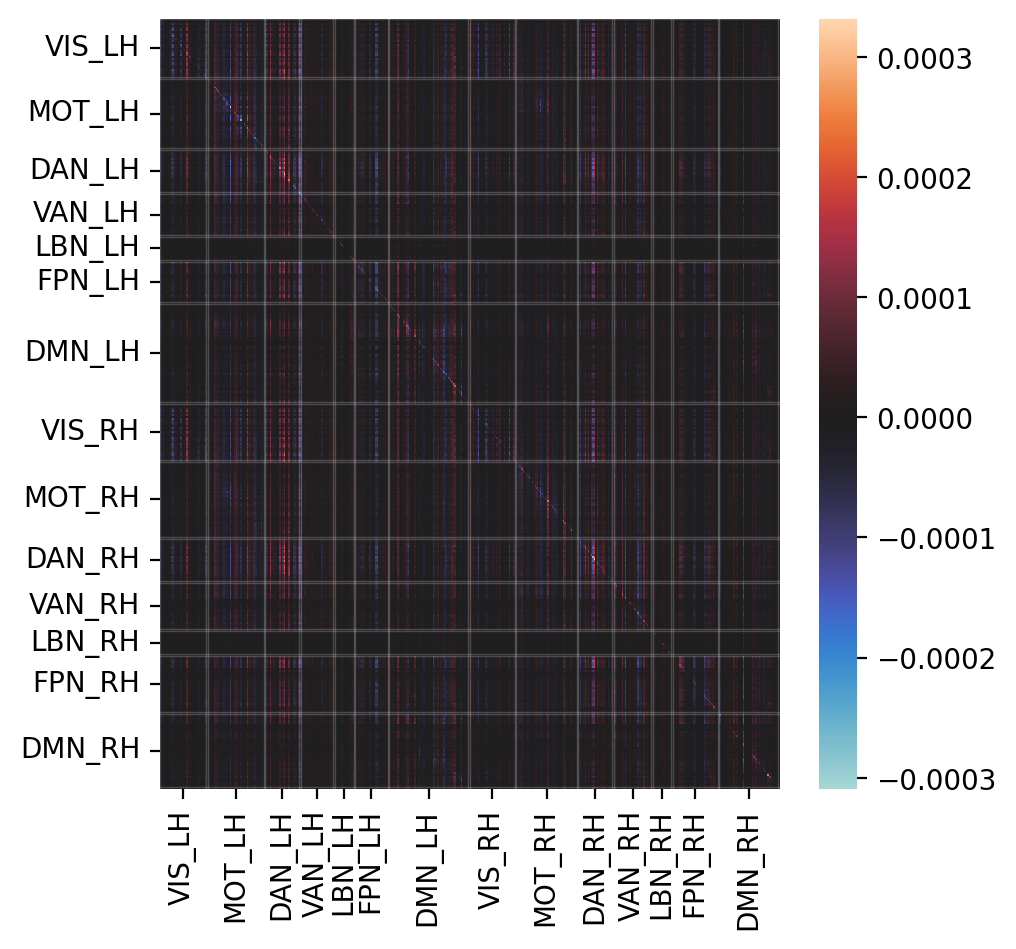

In [28]:
lw = 0.5
alpha = 0.2
plot = attributions[0]
plt.figure(figsize=(5, 5), dpi=200)
sns.heatmap(plot.mean(axis=0), cmap=attributions_cmap, center=0)
plt.xticks(ticks=xticks, labels=xticklabels, rotation=90)
plt.yticks(ticks=yticks, labels=yticklabels, rotation=0)
for v in networks_ids_for_plot.values():
    plt.axvline(v[0], color="white", linewidth=lw, alpha=alpha)
    plt.axhline(v[0], color="white", linewidth=lw, alpha=alpha)
    plt.axvline(v[1], color="white", linewidth=lw, alpha=alpha)
    plt.axhline(v[1], color="white", linewidth=lw, alpha=alpha)


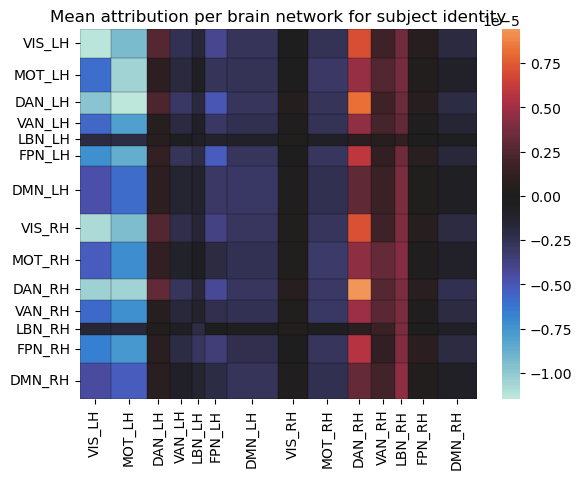

In [29]:
plot = attributions[0].mean(axis=0) 
plot = network_mean(plot)

sns.heatmap(plot, cmap=attributions_cmap, center=0)
plt.xticks(ticks=xticks, labels=xticklabels, rotation=90)
plt.yticks(ticks=yticks, labels=yticklabels, rotation=0)
for v in networks_ids_for_plot.values():
    plt.axvline(v[0], color="black", linewidth=lw, alpha=alpha)
    plt.axhline(v[0], color="black", linewidth=lw, alpha=alpha)
    plt.axvline(v[1], color="black", linewidth=lw, alpha=alpha)
    plt.axhline(v[1], color="black", linewidth=lw, alpha=alpha)
plt.title("Mean attribution per brain network for subject identity")
plt.show()


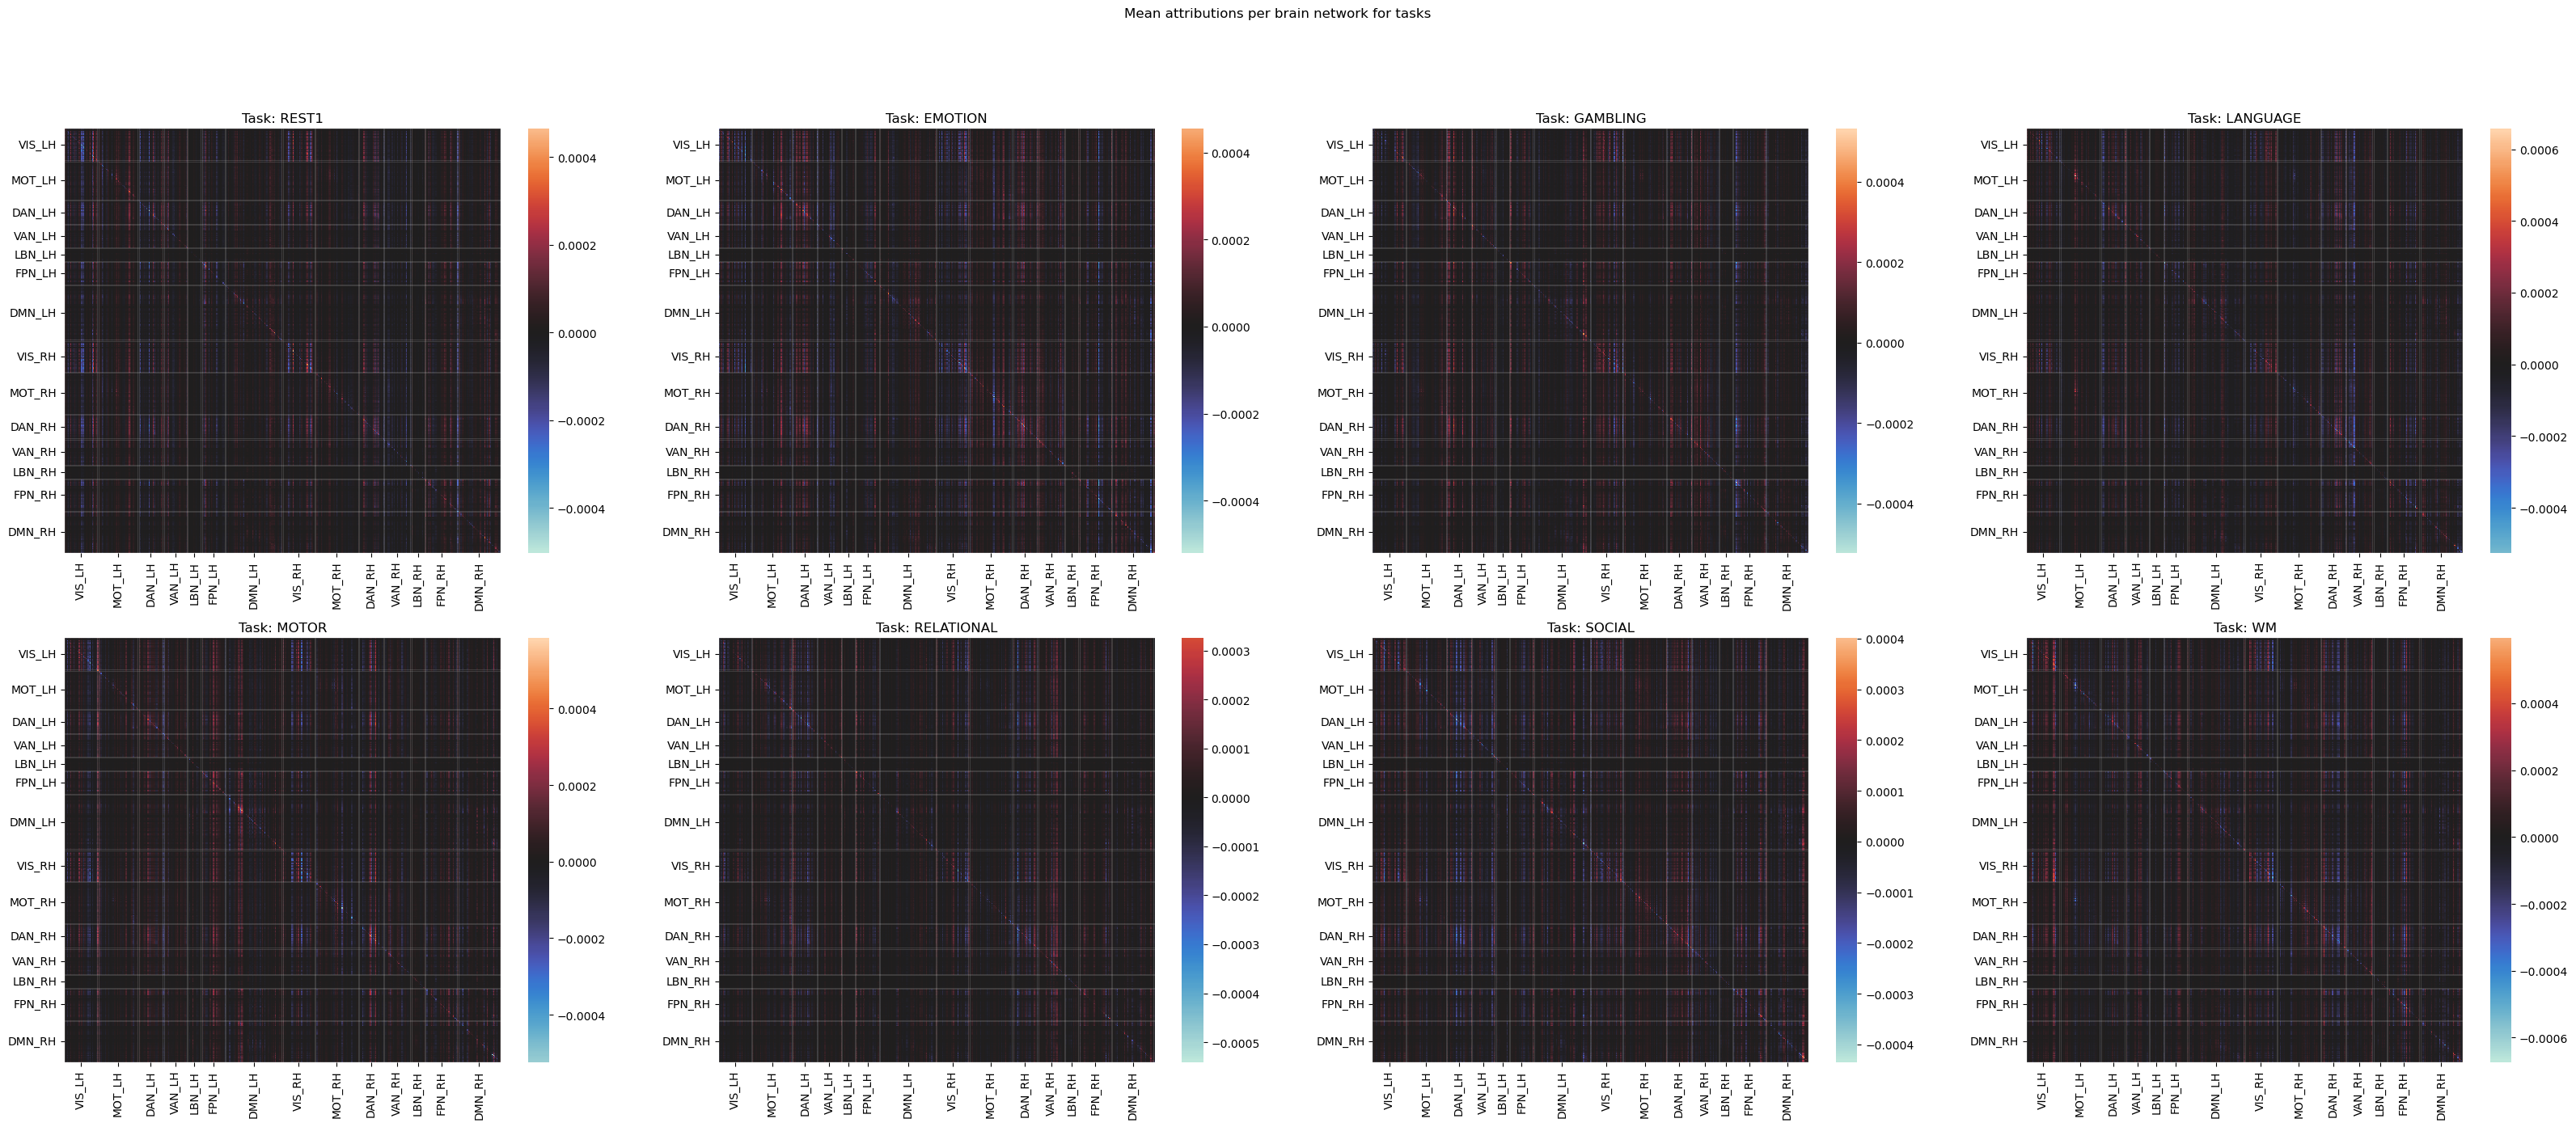

In [30]:
task_labels = [
            "REST1",
            "EMOTION",
            "GAMBLING",
            "LANGUAGE",
            "MOTOR",
            "RELATIONAL",
            "SOCIAL",
            "WM",
        ]

fig, axs = plt.subplots(2, 4, figsize=(40, 15), dpi=100)
for i, task in enumerate(task_labels):
    ax = axs.flatten()[i]
    sns.heatmap(attributions[i+1].mean(axis=0), cmap=attributions_cmap, center=0,ax=ax)
    ax.set_xticks(ticks=xticks, labels=xticklabels, rotation=90)
    ax.set_yticks(ticks=yticks, labels=yticklabels, rotation=0)
    for v in networks_ids_for_plot.values():
        ax.axvline(v[0], color="white", linewidth=lw, alpha=alpha)
        ax.axhline(v[0], color="white", linewidth=lw, alpha=alpha)
        ax.axvline(v[1], color="white", linewidth=lw, alpha=alpha)
        ax.axhline(v[1], color="white", linewidth=lw, alpha=alpha)
    ax.set_title(f"Task: {task}")
plt.suptitle(f"Mean attributions per brain network for tasks")
plt.show()

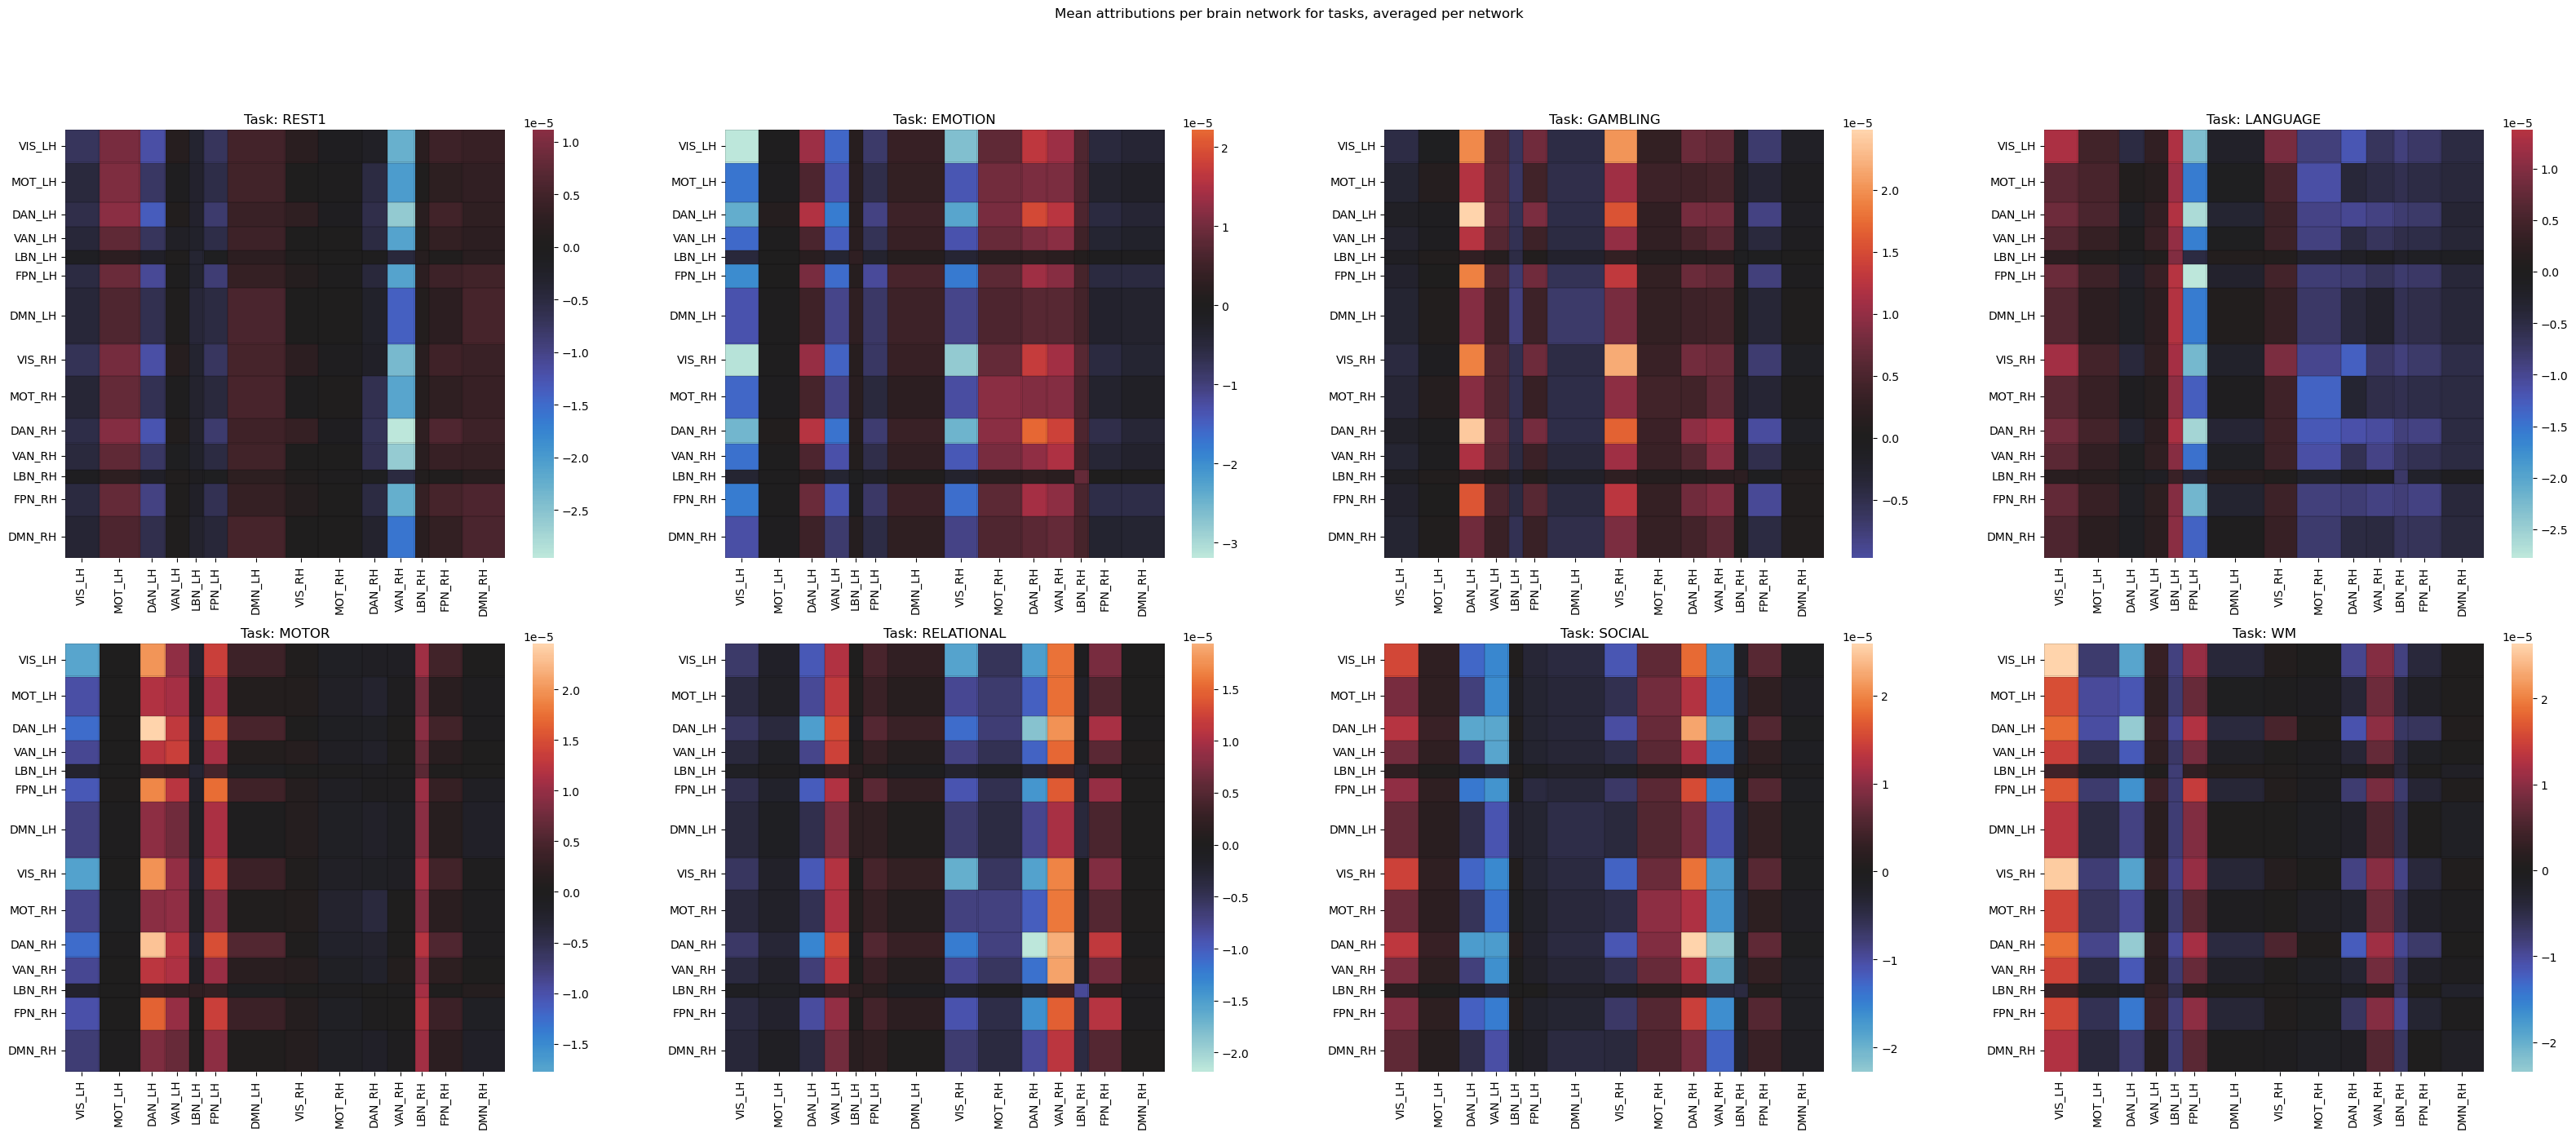

In [31]:
task_labels = [
            "REST1",
            "EMOTION",
            "GAMBLING",
            "LANGUAGE",
            "MOTOR",
            "RELATIONAL",
            "SOCIAL",
            "WM",
        ]

fig, axs = plt.subplots(2, 4, figsize=(40, 15))
for i, task in enumerate(task_labels):
    ax = axs.flatten()[i]
    window_mean = network_mean(attributions[i+1].mean(axis=0))
    sns.heatmap(window_mean, cmap=attributions_cmap, center=0,ax=ax)
    ax.set_xticks(ticks=xticks, labels=xticklabels, rotation=90)
    ax.set_yticks(ticks=yticks, labels=yticklabels, rotation=0)
    for v in networks_ids_for_plot.values():
        ax.axvline(v[0], color="black", linewidth=lw, alpha=alpha)
        ax.axhline(v[0], color="black", linewidth=lw, alpha=alpha)
        ax.axvline(v[1], color="black", linewidth=lw, alpha=alpha)
        ax.axhline(v[1], color="black", linewidth=lw, alpha=alpha)
    ax.set_title(f"Task: {task}")
plt.suptitle(f"Mean attributions per brain network for tasks, averaged per network")
plt.show()

In [35]:
# subtract SI attributions from task attributions
# task_attributions = attributions[1:]
# subtraction = task_attributions - attributions[0]
# # plot subtractions
# fig, axs = plt.subplots(2, 4, figsize=(25, 10))
# for i, task in enumerate(task_labels):
#     ax = axs.flatten()[i]
#     window_mean = network_mean(subtraction[i].mean(axis=0))
#     sns.heatmap(window_mean, cmap=attributions_cmap, center=0,ax=ax)
#     ax.set_xticks(ticks=xticks, labels=xticklabels, rotation=0)
#     ax.set_yticks(ticks=yticks, labels=yticklabels, rotation=0)
#     for v in networks_ids_for_plot.values():
#         ax.axvline(v[0], color="black", linewidth=lw, alpha=alpha)
#         ax.axhline(v[0], color="black", linewidth=lw, alpha=alpha)
#         ax.axvline(v[1], color="black", linewidth=lw, alpha=alpha)
#         ax.axhline(v[1], color="black", linewidth=lw, alpha=alpha)
#     ax.set_title(f"Task: {task}")

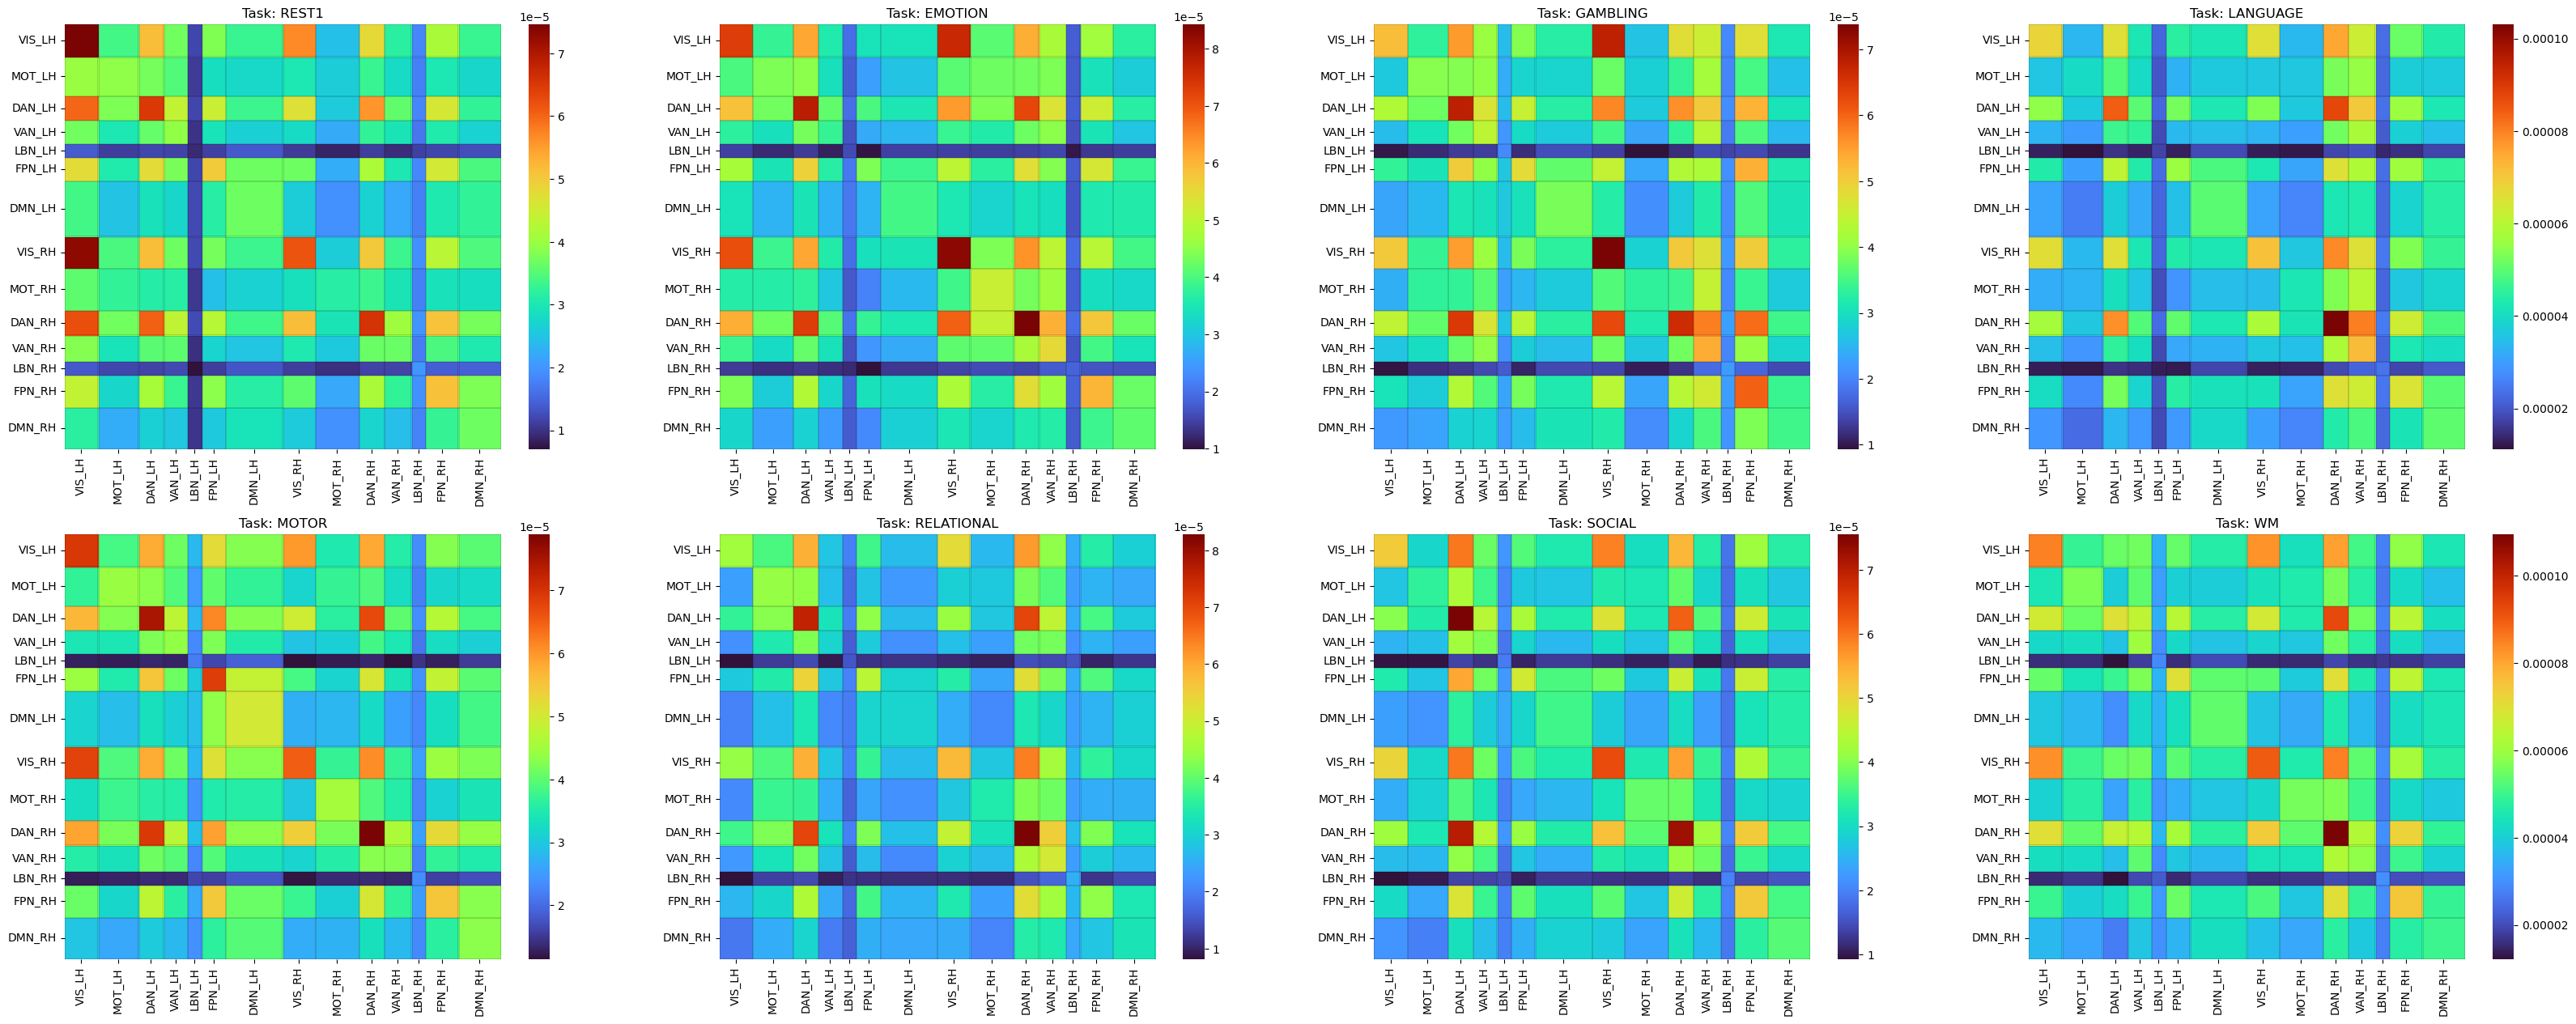

In [40]:
# plot absolute values of attributions
fig, axs = plt.subplots(2, 4, figsize=(40, 15))
attributions_cmap = "turbo"
for i, task in enumerate(task_labels):
    ax = axs.flatten()[i]
    window_mean = network_mean(np.abs(attributions[i+1]).mean(axis=0))
    sns.heatmap(window_mean, cmap=attributions_cmap,ax=ax)
    ax.set_xticks(ticks=xticks, labels=xticklabels, rotation=90)
    ax.set_yticks(ticks=yticks, labels=yticklabels, rotation=0)
    for v in networks_ids_for_plot.values():
        ax.axvline(v[0], color="black", linewidth=lw, alpha=alpha)
        ax.axhline(v[0], color="black", linewidth=lw, alpha=alpha)
        ax.axvline(v[1], color="black", linewidth=lw, alpha=alpha)
        ax.axhline(v[1], color="black", linewidth=lw, alpha=alpha)
    ax.set_title(f"Task: {task}")

In [34]:
# reorder to have LR fixed
# take row abs+mean and project back to 400 brain regions
# plot of acc per intermediate layer num of neurons -> show with/without dropout for dim 100